In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import joblib
from datasets import load_dataset
from sklearn.metrics import accuracy_score

In [61]:
model = joblib.load("../models/baseline_model.pkl")
vectorizer = joblib.load("../models/vectorizer.pkl")

In [62]:
dataset = load_dataset("imdb")
test_data = pd.DataFrame(dataset["test"])
test_data = test_data.sample(1000, random_state=42)

In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [64]:
x_test_clean = test_data["text"].apply(clean_text)
x_vec = vectorizer.transform(x_test_clean)
y_true = test_data["label"]
y_pred = model.predict(x_vec)
baseline_accuracy = accuracy_score(y_true, y_pred)
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.857


In [65]:
import random
def heavy_noise(text):
    words = text.split()
    words = words[:len(words)//2]
    words += ["xyz", "noise", "qwerty"]
    return " ".join(words)

In [66]:
x_test_noisy = x_test_clean.apply(heavy_noise)
x_vec_noisy = vectorizer.transform(x_test_noisy)
y_pred_noisy = model.predict(x_vec_noisy)
noisy_accuracy = accuracy_score(y_true, y_pred_noisy)
print("Noisy Accuracy:", noisy_accuracy)
print("Drop:", baseline_accuracy - noisy_accuracy)

Noisy Accuracy: 0.796
Drop: 0.06099999999999994


FRAGILE PIPELINE

In [ ]:
x_test_corrupt = x_test_clean.copy()
x_test_corrupt.iloc[0:200] = None

In [71]:
try:
    x_vec_fragile = vectorizer.transform(x_test_corrupt)
    y_pred_fragile = model.predict(x_vec_fragile)
    fragile_accuracy = accuracy_score(y_true, y_pred_fragile)
    print("Fragile Accuracy:", fragile_accuracy)
except Exception as e:
    print("Fragile pipeline failed:", e)
    fragile_accuracy = None

Fragile pipeline failed: np.nan is an invalid document, expected byte or unicode string.


ROBUST PIPELINE

In [72]:
def validate_input(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    return text

In [73]:
def robust_pipeline_predict(text_series):
    validated = text_series.apply(validate_input)
    cleaned = validated.apply(clean_text)
    vec = vectorizer.transform(cleaned)
    preds = model.predict(vec)
    return preds

In [74]:
y_pred_robust = robust_pipeline_predict(x_test_corrupt)
robust_accuracy = accuracy_score(y_true, y_pred_robust)
print("Robust Accuracy:", robust_accuracy)

Robust Accuracy: 0.778


In [76]:
comparison = pd.DataFrame([
    {"Pipeline": "Fragile", "Accuracy": fragile_accuracy if fragile_accuracy is not None else "Failed"},
    {"Pipeline": "Robust", "Accuracy": robust_accuracy}
])
comparison

,Pipeline,Accuracy
0,Fragile,Failed
1,Robust,0.778


In [80]:
comparison = pd.DataFrame([
    {
        "Pipeline": "Fragile",
        "Accuracy": fragile_accuracy if fragile_accuracy is not None else 0,
        "Status": "Failed" if fragile_accuracy is None else "OK"
    },
    {
        "Pipeline": "Robust",
        "Accuracy": robust_accuracy,
        "Status": "OK"
    }
])
comparison

,Pipeline,Accuracy,Status
0,Fragile,0.000,Failed
1,Robust,0.778,OK


In [84]:
final_results = pd.DataFrame([
    {"Experiment": "Baseline", "Accuracy": baseline_accuracy},
    {"Experiment": "Heavy Noise", "Accuracy": noisy_accuracy},
    {"Experiment": "Robust Pipeline", "Accuracy": robust_accuracy}
])
final_results

,Experiment,Accuracy
0,Baseline,0.857
1,Heavy Noise,0.796
2,Robust Pipeline,0.778


DATA VISUALIZATION

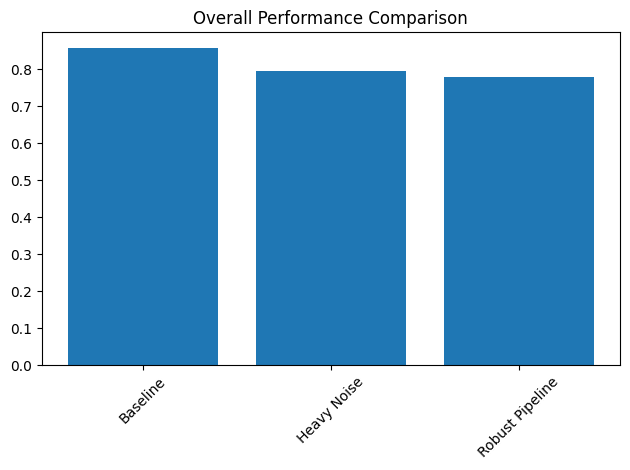

In [85]:
plt.figure()
plt.bar(final_results["Experiment"], final_results["Accuracy"])
plt.title("Overall Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

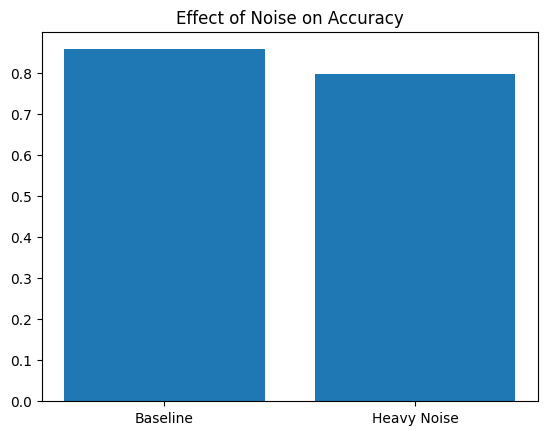

In [78]:
plt.figure()
plt.bar(["Baseline", "Heavy Noise"], [baseline_accuracy, noisy_accuracy])
plt.title("Effect of Noise on Accuracy")
plt.show()

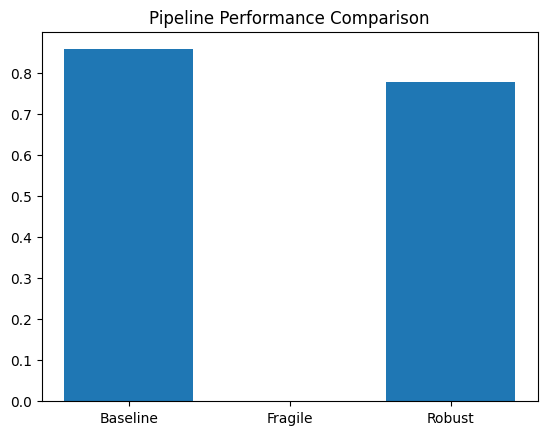

In [82]:
plot_data = pd.DataFrame([
    {"Pipeline": "Baseline", "Accuracy": baseline_accuracy},
    {"Pipeline": "Fragile", "Accuracy": fragile_accuracy if fragile_accuracy is not None else 0},
    {"Pipeline": "Robust", "Accuracy": robust_accuracy}
])

plt.figure()
plt.bar(plot_data["Pipeline"], plot_data["Accuracy"])
plt.title("Pipeline Performance Comparison")
plt.show()

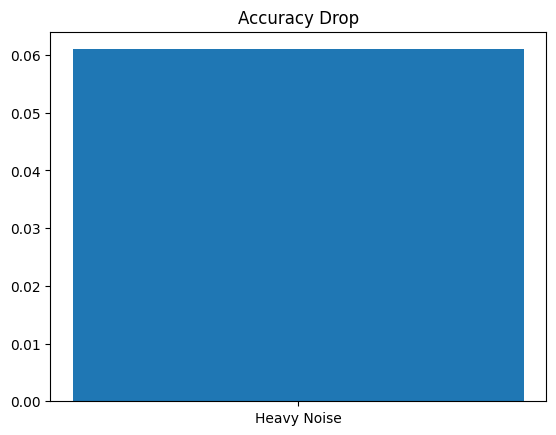

In [83]:
drop = baseline_accuracy - noisy_accuracy
plt.figure()
plt.bar(["Heavy Noise"], [drop])
plt.title("Accuracy Drop")
plt.show()

Severity Analysis

Baseline accuracy was 0.857.
Heavy noise reduced accuracy to 0.796, representing a moderate fragility of the pipeline under distribution shift.

The fragile pipeline failed under corrupted input conditions, demonstrating critical fragility due to lack of validation.

The robust pipeline maintained stable performance by introducing input validation and normalization steps.

-------------------------------------------

Root Cause Analysis

The sentiment analysis pipeline relies on TF-IDF feature extraction, which assumes consistent vocabulary and input quality.
Heavy noise degraded feature quality by removing meaningful tokens and introducing irrelevant tokens.

Corrupted inputs caused the fragile pipeline to fail because no validation layer was present before vectorization.

Introducing input validation mitigated this issue and improved robustness.

-------------------------------------------

Mitigation Strategies

To reduce architectural fragility in ML pipelines:

Validate inputs before preprocessing

Normalize text consistently

Monitor input distributions for drift

Add fallback mechanisms for corrupted data

-------------------------------------------

Conclusion

This study demonstrates that machine learning pipelines can exhibit fragility when exposed to noisy or corrupted inputs.

The experiments showed:

Moderate performance degradation under distribution shift

Critical failure in the absence of input validation

Improved robustness when validation mechanisms were introduced

These results highlight the importance of architectural safeguards in production AI systems.

In [86]:
final_results.to_csv("../results/final_results.csv", index=False)